In [170]:
import optiland.backend as be
from optiland.optic import Optic
from optiland.materials import IdealMaterial
from optiland.rays import RealRays
from optiland.analysis import SpotDiagram
import torch
import matplotlib.pyplot as plt

In [177]:
class Lens(Optic):
    def __init__(self):
        super().__init__()
        
        self.add_surface(index=0, thickness=be.inf)
        self.add_surface(
            index=1,
            radius=30,
            surface_type="standard",
            thickness=4.0,
            material=IdealMaterial(n=1.5, k=0),
            is_stop=True,
        )
        self.add_surface(index=2, thickness=35.0, radius=-10000000, material="air") # we might have to correct some things cause it breaks when its radius = be.inf
        self.add_surface(index=3)
        
        self.set_aperture(aperture_type="EPD", value=20.0)
        self.add_wavelength(value=0.550, is_primary=True)
        self.set_field_type("angle")
        self.add_field(y=0)


In [178]:
be.set_backend("torch")
be.set_device(
    "cpu"
)  # we will stick to cpu for now. "cuda" is also possible for GPU calculations.
print(be.get_precision())  # check the precision

# enable the gradient mode: to tell autograd to begin recording operations on a Tensor tensor
be.grad_mode.enable()

torch.float32


In [179]:
lens = Lens()

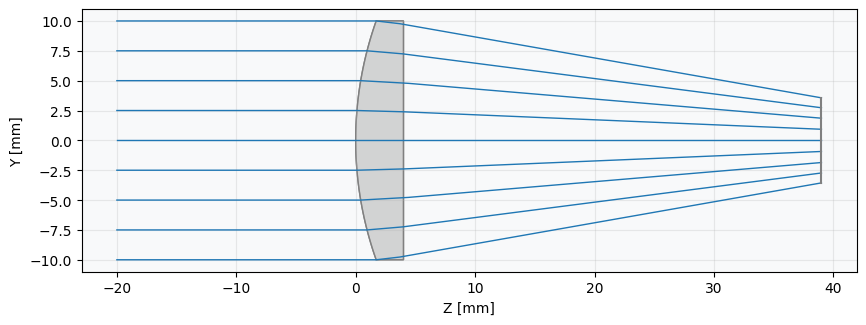

In [180]:
lens.draw(num_rays=9)

In [181]:
# Get initial values
r1 = lens.surface_group.surfaces[1].geometry.radius
r2 = lens.surface_group.surfaces[2].geometry.radius
params_to_optimize = [r1, r2]
print(params_to_optimize)

[tensor(30., requires_grad=True), tensor(-10000000., requires_grad=True)]


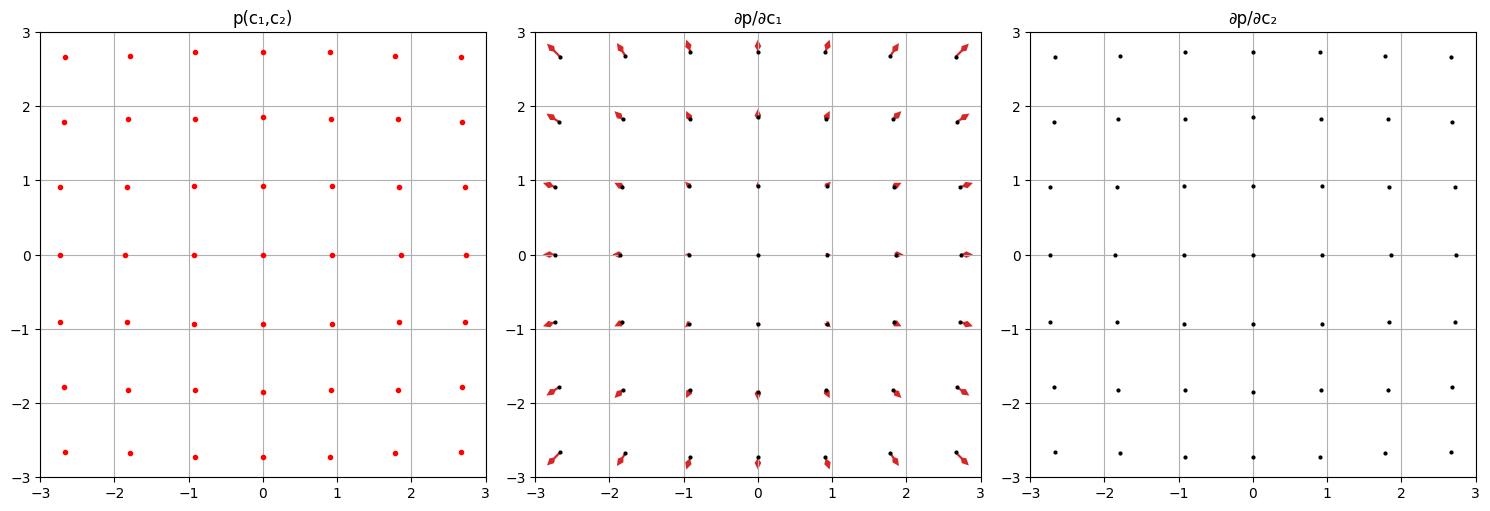

In [183]:
import torch
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt


x_coords = torch.linspace(-10.0, 10.0, 9)
y_coords = torch.linspace(-10.0, 10.0, 9)

X, Y = torch.meshgrid(x_coords, y_coords, indexing='xy')    

x_in = X.reshape(-1)   
y_in = Y.reshape(-1)   
z_in = be.zeros_like(x_in)
L_in = be.zeros_like(x_in)
M_in = be.zeros_like(x_in)
N_in = be.ones_like(x_in)
intensity = be.ones_like(x_in)

rays_in = RealRays(x=x_in, y=y_in, z=z_in,
                   L=L_in, M=M_in, N=N_in,
                   wavelength=0.550, intensity=intensity)


rays_out   = lens.surface_group.trace(rays_in)
num_surf   = lens.surface_group.num_surfaces
x_image    = lens.surface_group.x[num_surf - 1, :]
y_image    = lens.surface_group.y[num_surf - 1, :]

# get dp/dc1, dp/dr2 
dp_dr1_list = []
dp_dr2_list = []

n_rays = x_image.shape[0]
for i in range(n_rays):
    # one‐hot on GPU/CPU, no grad‐tracking needed for this 
    one_hot = torch.nn.functional.one_hot(torch.tensor(i, device=x_image.device),
                                          num_classes=n_rays).to(x_image.dtype)

    grads_x = autograd.grad(outputs=x_image,
                            inputs=[r1, r2],
                            grad_outputs=one_hot,
                            retain_graph=True)
    grads_y = autograd.grad(outputs=y_image,
                            inputs=[r1, r2],
                            grad_outputs=one_hot,
                            retain_graph=True)

    gx_r1, gx_r2 = grads_x
    gy_r1, gy_r2 = grads_y

    dp_dr1_list.append(torch.stack([gx_r1, gy_r1]))
    dp_dr2_list.append(torch.stack([gx_r2, gy_r2]))

dp_dr1 = torch.stack(dp_dr1_list).detach().numpy()
dp_dr2 = torch.stack(dp_dr2_list).detach().numpy()
x_plot = x_image.detach().numpy()
y_plot = y_image.detach().numpy()


fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(x_plot, y_plot, 'r.', ms=6)
axs[0].set_xlim(-3,3);  axs[0].set_ylim(-3,3)
axs[0].set_aspect('equal');  axs[0].grid(True)
axs[0].set_title('p(c₁,c₂)')

arrow_scale = 1.0
for ax, D, title in zip(axs[1:], (dp_dr1, dp_dr2), ('∂p/∂c₁','∂p/∂c₂')):
    ax.plot(x_plot, y_plot, 'k.', ms=4)
    ax.quiver(
        x_plot, y_plot,
        D[:,0]*arrow_scale, D[:,1]*arrow_scale,
        angles='xy', scale_units='xy', scale=1,
        width=0.005, headwidth=3, headlength=3, color='tab:red'
    )
    ax.set_xlim(-3,3);  ax.set_ylim(-3,3)
    ax.set_aspect('equal');  ax.grid(True)
    ax.set_title(title)

plt.tight_layout()
plt.show()
